# Deep Q Networks

This notebook demonstrates how to solve OpenAI gym environments using DQN. It defaults to the LunarLander-v2 environment. Based on the environment, the network might need to be structured differently.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from replay_buffer import ReplayBuffer
from torchsummary import summary
from torchvision import transforms
from typing import List, Tuple

import build.pacman_rl as pacman_rl
import IPython.display
import time

In [2]:
# class DQN(nn.Module):
#     def __init__(
#         self,
#         input_dims: int,
#         num_actions: int,
#     ) -> None:
#         super().__init__()

#         self.input_dims = input_dims
#         self.num_actions = num_actions

#         def block(in_features: int, out_features: int) -> nn.Sequential:
#             return nn.Sequential(
#                 nn.Linear(in_features=in_features, out_features=out_features),
#                 nn.LeakyReLU(0.25),
#             )

#         self.network = nn.Sequential(
#             block(input_dims, 256),
#             block(256, 128),
#         )
#         self.Q = nn.Sequential(
#             nn.Linear(in_features=128, out_features=num_actions), nn.LeakyReLU(0.25)
#         )

#     def forward(self, state: torch.FloatTensor) -> torch.FloatTensor:
#         x = self.network(state)
#         Q = self.Q(x)
#         return Q


class DQN(nn.Module):
    def __init__(self, input_dims: Tuple[int, int, int], num_actions: int) -> None:
        super().__init__()

        self.input_dims = input_dims
        self.num_actions = num_actions

        self.conv_net = nn.Sequential(
            nn.Conv2d(
                in_channels=input_dims[2],
                out_channels=16,
                kernel_size=5,
                padding=2,
                stride=1,
            ),
            nn.MaxPool2d(kernel_size=5, padding=2, stride=2),
            nn.LeakyReLU(0.20),
            nn.Conv2d(
                in_channels=16, out_channels=32, kernel_size=5, padding=2, stride=1
            ),
            nn.MaxPool2d(kernel_size=5, padding=2, stride=2),
            nn.LeakyReLU(0.20),
            nn.Conv2d(
                in_channels=32, out_channels=32, kernel_size=5, padding=2, stride=1
            ),
            nn.MaxPool2d(kernel_size=3, padding=1, stride=2),
            nn.LeakyReLU(0.20),
        )

        self.fc_input_size = self._get_conv_output_size()

        self.fc_net = nn.Sequential(
            nn.Linear(self.fc_input_size, 32),
            nn.LeakyReLU(0.20),
            nn.Linear(32, num_actions),
        )

    def _get_conv_output_size(self):
        test_input = torch.randn(
            1, self.input_dims[2], self.input_dims[0], self.input_dims[1]
        )
        test_output = self.conv_net(test_input)
        return test_output.view(test_output.size(0), -1).size(1)

    def forward(self, state: torch.FloatTensor) -> torch.FloatTensor:
        state = state.view(
            -1, self.input_dims[2], self.input_dims[0], self.input_dims[1]
        )
        x = self.conv_net(state)
        x = x.view(x.size(0), -1)
        Q = self.fc_net(x)
        return Q


class DQNAgent:
    def __init__(
        self,
        input_dims: int,
        num_actions: int,
        *,
        environment: str = "",
        learning_rate: float = 0.001,
        gamma: float = 0.99,
        batch_size: int = 64,
        epsilon: float = 1,
        epsilon_decrement: float = 0.001,
        min_epsilon: float = 0.01,
        memory_size: int = 100000,
        filename: str = "agent",
        device: str = "cpu",
        warmup_steps: int = 100,
    ) -> None:
        self.input_dims = input_dims
        self.num_actions = num_actions
        self.environment = environment
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epsilon_decrement = epsilon_decrement
        self.min_epsilon = min_epsilon
        self.memory_size = memory_size
        self.filename = f"{environment}_{filename}"
        self.device = device
        self.warmup_steps = warmup_steps

        self.action_space = list(range(num_actions))
        self.memory = ReplayBuffer(memory_size, input_dims)
        self.network = DQN(input_dims=input_dims, num_actions=num_actions).to(
            self.device
        )

        self.loss_fn = nn.HuberLoss()
        self.optimizer = optim.AdamW(self.network.parameters(), lr=learning_rate)

    def get_training_action(self, observation: np.ndarray) -> int:
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state = torch.tensor(np.array([observation])).to(self.device)
            actions = self.network(state)
            action = torch.argmax(actions).item()
        return int(action)

    def get_testing_action(self, observation: np.ndarray) -> int:
        state = torch.tensor(np.array([observation])).to(self.device)
        actions = self.network(state)
        action = torch.argmax(actions).item()
        return int(action)

    def learn(self) -> None:
        self.network.train()

        # Do not learn if there are not enough experiences in the replay buffer
        if self.memory.memory_counter < self.warmup_steps:
            return

        self.optimizer.zero_grad()

        # Sample a batch of experiences from the replay buffer
        states, actions, rewards, next_states, terminals = map(
            lambda x: torch.tensor(x).to(self.device),
            self.memory.sample_buffer(self.batch_size),
        )
        batch_indices = np.arange(self.batch_size)

        # Compute Q-values for current states
        q_eval = self.network(states)[batch_indices, actions]

        # Compute Q-values for next states
        q_next = self.network.forward(next_states)
        q_next[terminals] = 0

        q_target = rewards + self.gamma * torch.max(q_next, dim=1)[0]

        # Compute and backpropagate the loss
        loss = self.loss_fn(q_target, q_eval)
        loss.backward()
        self.optimizer.step()

        # Epsilon-greedy policy
        self.epsilon = (
            self.epsilon - self.epsilon_decrement
            if self.epsilon > self.min_epsilon
            else self.min_epsilon
        )

    def save_model(self) -> None:
        torch.save(self.network, f"{self.filename}.pt")

    def load_model(self) -> None:
        self.network = torch.load(f"{self.filename}.pt")


class DoubleDQNAgent:
    def __init__(
        self,
        input_dims: int,
        num_actions: int,
        *,
        environment: str = "",
        learning_rate: float = 0.001,
        gamma: float = 0.99,
        batch_size: int = 64,
        epsilon: float = 1,
        epsilon_decrement: float = 0.001,
        min_epsilon: float = 0.01,
        memory_size: int = 100000,
        filename: str = "agent",
        device: str = "cpu",
        warmup_steps: int = 100,
        target_network_update_frequency: int = 100,
    ) -> None:
        self.input_dims = input_dims
        self.num_actions = num_actions
        self.environment = environment
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epsilon_decrement = epsilon_decrement
        self.min_epsilon = min_epsilon
        self.memory_size = memory_size
        self.filename = f"{environment}_{filename}"
        self.device = device
        self.warmup_steps = warmup_steps
        self.target_network_update_frequency = target_network_update_frequency

        self.action_space = list(range(num_actions))
        self.memory = ReplayBuffer(memory_size, input_dims)
        self.network = DQN(input_dims=input_dims, num_actions=num_actions).to(
            self.device
        )
        self.target_network = DQN(input_dims=input_dims, num_actions=num_actions).to(
            self.device
        )
        self.step_count = 0

        self.loss_fn = nn.HuberLoss()
        self.optimizer = optim.AdamW(self.network.parameters(), lr=learning_rate)

    def get_training_action(self, observation: np.ndarray) -> int:
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state = torch.tensor(np.array([observation])).to(self.device)
            actions = self.network(state)
            action = torch.argmax(actions).item()
        return int(action)

    def get_testing_action(self, observation: np.ndarray) -> int:
        state = torch.tensor(np.array([observation])).to(self.device)
        actions = self.network(state)
        action = torch.argmax(actions).item()
        return int(action)

    def learn(self) -> None:
        self.network.train()

        # Do not learn if there are not enough experiences in the replay buffer
        if self.memory.memory_counter < self.warmup_steps:
            return

        if self.step_count % self.target_network_update_frequency == 0:
            self.target_network.load_state_dict(self.network.state_dict())

        self.optimizer.zero_grad()

        # Sample a batch of experiences from the replay buffer
        states, actions, rewards, next_states, terminals = map(
            lambda x: torch.tensor(x).to(self.device),
            self.memory.sample_buffer(self.batch_size),
        )
        batch_indices = np.arange(self.batch_size)

        # Compute Q-values for the current states using the evaluation network
        q_eval = self.network(states)[batch_indices, actions]

        # Compute Q-values for the next states using the target network
        q_next = self.target_network.forward(next_states)
        q_next[terminals] = 0

        q_target = rewards + self.gamma * torch.max(q_next, dim=1)[0]

        # Compute and backpropagate the loss
        loss = self.loss_fn(q_target, q_eval)
        loss.backward()
        self.optimizer.step()

        # Epsilon-greedy policy
        self.epsilon = (
            self.epsilon - self.epsilon_decrement
            if self.epsilon > self.min_epsilon
            else self.min_epsilon
        )

        self.step_count += 1

    def save_model(self) -> None:
        torch.save(self.network, f"{self.filename}_eval_network.pt")
        torch.save(self.target_network, f"{self.filename}_target_network.pt")

    def load_model(self) -> None:
        self.network = torch.load(f"{self.filename}_eval_network.pt")
        self.target_network = torch.load(f"{self.filename}_target_network.pt")

In [3]:
class ImageStack:
    def __init__(self, size: int) -> None:
        self.size = size
        self.image_stack: np.ndarray = None

    def step(self, image: torch.Tensor) -> None:
        if self.image_stack is None:
            self.image_stack = image[None, ...]
        else:
            self.image_stack = torch.concat([self.image_stack, image[None, ...]])
        if self.image_stack.shape[0] > self.size:
            self.image_stack = self.image_stack[-self.size :]

    def item(self) -> torch.Tensor:
        return self.image_stack

In [4]:
def encode_grid(grid: List[str]):
    rows = len(grid)
    cols = len(grid[0])
    grid: np.ndarray = np.array(list(map(list, grid))).reshape(-1)
    grid[grid == " "] = 0
    grid[grid == "#"] = 1
    grid[grid == "."] = 2
    grid[grid == "@"] = 3
    grid[grid == "G"] = 4
    grid[grid == "0"] = 5
    grid[grid == "1"] = 6
    grid[grid == "2"] = 7
    grid[grid == "3"] = 8
    grid[grid == "P"] = 9
    grid = grid.astype(np.float32)
    grid = grid / 9.0
    grid = grid * 2 - 1
    return grid.reshape((rows, cols))
    # encoded = []
    # for i in range(rows):
    #     for j in range(cols):
    #         index = i * cols + j
    #         encoded.append(grid[index])
    #         encoded.append(i / rows)
    #         encoded.append(j / cols)
    # return np.array(encoded, dtype=np.float32)

In [5]:
max_episode_steps = 400
config = pacman_rl.Config()
config.rows = 21
config.cols = 19
config.max_episode_steps = max_episode_steps
config.pacman_lives = 3
config.map = [
    "###################",
    "#........#........#",
    "#@##.###.#.###.##@#",
    "#.................#",
    "#.##.#.#####.#.##.#",
    "#....#...#...#....#",
    "####.###.#.###.####",
    "####.#...0...#.####",
    "####.#.##G##.#.####",
    "#......#123#......#",
    "####.#.#####.#.####",
    "####.#...P...#.####",
    "####.#.#####.#.####",
    "#........#........#",
    "#.##.###.#.###.##.#",
    "#@.#...........#.@#",
    "##.#.#.#####.#.#.##",
    "#....#...#...#....#",
    "#.######.#.######.#",
    "#.................#",
    "###################",
]

In [6]:
# input_dims = (encode_grid(config.map).shape[0],)
# input_dims = (config.rows, config.cols)
image_stack_size = 3
input_dims = (128, 128, image_stack_size * 3)  # image_stack_size * RGB_channels
num_actions = 4
learning_rate = 1e-3
gamma = 0.99
batch_size = 64
epsilon = 1
epsilon_decrement = 0.00001
min_epsilon = 0.05
memory_size = 20000
environment = "pacman"
filename = "dqn_agent"
warmup_steps = 2500
target_network_update_frequency = 1000
device = "cuda" if torch.cuda.is_available() else "cpu"

num_episodes = 400
max_episode_steps = 400
num_learning_steps = 25

In [7]:
# agent = DQNAgent(
#     input_dims=input_dims,
#     num_actions=num_actions,
#     learning_rate=learning_rate,
#     gamma=gamma,
#     batch_size=batch_size,
#     epsilon=epsilon,
#     epsilon_decrement=epsilon_decrement,
#     min_epsilon=min_epsilon,
#     memory_size=memory_size,
#     environment=environment,
#     filename=filename,
#     warmup_steps=warmup_steps,
#     device=device,
# )

pacman_env = pacman_rl.make(config, mode=pacman_rl.RenderMode.HUMAN)
env = pacman_rl.RecordVideoEnvironment(pacman_env)

image_stack = ImageStack(size=image_stack_size)

agent = DoubleDQNAgent(
    input_dims=input_dims,
    num_actions=num_actions,
    learning_rate=learning_rate,
    gamma=gamma,
    batch_size=batch_size,
    epsilon=epsilon,
    epsilon_decrement=epsilon_decrement,
    min_epsilon=min_epsilon,
    memory_size=memory_size,
    environment=environment,
    filename=filename,
    warmup_steps=warmup_steps,
    target_network_update_frequency=target_network_update_frequency,
    device=device,
)

In [8]:
_ = summary(
    agent.network,
    input_data=(input_dims[2], input_dims[0], input_dims[1]),
    device=device,
)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 16, 16]          --
|    └─Conv2d: 2-1                       [-1, 16, 128, 128]        3,616
|    └─MaxPool2d: 2-2                    [-1, 16, 64, 64]          --
|    └─LeakyReLU: 2-3                    [-1, 16, 64, 64]          --
|    └─Conv2d: 2-4                       [-1, 32, 64, 64]          12,832
|    └─MaxPool2d: 2-5                    [-1, 32, 32, 32]          --
|    └─LeakyReLU: 2-6                    [-1, 32, 32, 32]          --
|    └─Conv2d: 2-7                       [-1, 32, 32, 32]          25,632
|    └─MaxPool2d: 2-8                    [-1, 32, 16, 16]          --
|    └─LeakyReLU: 2-9                    [-1, 32, 16, 16]          --
├─Sequential: 1-2                        [-1, 4]                   --
|    └─Linear: 2-10                      [-1, 32]                  262,176
|    └─LeakyReLU: 2-11                   [-1, 32]                  --

In [9]:
seed = 1337
torch.manual_seed(seed)
np.random.seed(seed)

In [10]:
preprocess = transforms.Compose(
    [
        transforms.Resize(input_dims[:2]),
        transforms.ToTensor(),
    ]
)

postprocess = transforms.ToPILImage()

In [11]:
scores = []
actual_scores = []

for i in range(num_episodes):
    steps = 0
    state = env.reset()
    prev_score = 0
    score = 0
    done = False

    while not state.completed:
        #         filename = "test.png"
        #         pacman_rl.render_grid_to_png(state.grid, filename)
        env.render()
        filename = env.get_snapshot()
        img = Image.open(filename).convert("RGB")
        image_stack.step(preprocess(img))

        if image_stack.item().shape[0] < image_stack_size:
            continue

        old_image_stack = image_stack.item().detach().cpu().numpy().reshape(input_dims)
        action = agent.get_training_action(image_stack.item().detach().cpu().numpy())
        action = pacman_rl.MovementDirection(action)

        new_state = env.step(action)
        new_image_stack = image_stack.item().detach().cpu().numpy().reshape(input_dims)
        reward = (new_state.score - prev_score) / 10

        score += reward
        agent.memory.store_transition(
            old_image_stack, action, reward, new_image_stack, new_state.completed
        )
        agent.learn()
        steps += 1

        state = new_state
        prev_score = state.score

    if agent.epsilon <= agent.min_epsilon:
        for _ in range(num_learning_steps):
            agent.learn()

    scores.append(score)
    actual_scores.append(state.score)
    print(
        f"Episode: {i:03}, Steps: {steps:03}, Score: {score:.3f}, Actual Score: {state.score}"
    )

Episode: 000, Steps: 143, Score: 11.000, Actual Score: 110
Episode: 001, Steps: 166, Score: 26.000, Actual Score: 260
Episode: 002, Steps: 097, Score: 11.000, Actual Score: 110
Episode: 003, Steps: 216, Score: 24.000, Actual Score: 240
Episode: 004, Steps: 172, Score: 17.000, Actual Score: 170
Episode: 005, Steps: 132, Score: 10.000, Actual Score: 100
Episode: 006, Steps: 112, Score: 7.000, Actual Score: 70
Episode: 007, Steps: 246, Score: 23.000, Actual Score: 230
Episode: 008, Steps: 115, Score: 13.000, Actual Score: 130
Episode: 009, Steps: 069, Score: 19.000, Actual Score: 190
Episode: 010, Steps: 107, Score: 16.000, Actual Score: 160
Episode: 011, Steps: 082, Score: 13.000, Actual Score: 130
Episode: 012, Steps: 124, Score: 13.000, Actual Score: 130
Episode: 013, Steps: 060, Score: 15.000, Actual Score: 150
Episode: 014, Steps: 162, Score: 27.000, Actual Score: 270
Episode: 015, Steps: 174, Score: 27.000, Actual Score: 270
Episode: 016, Steps: 107, Score: 13.000, Actual Score: 130

KeyboardInterrupt: 

In [14]:
agent.save_model()

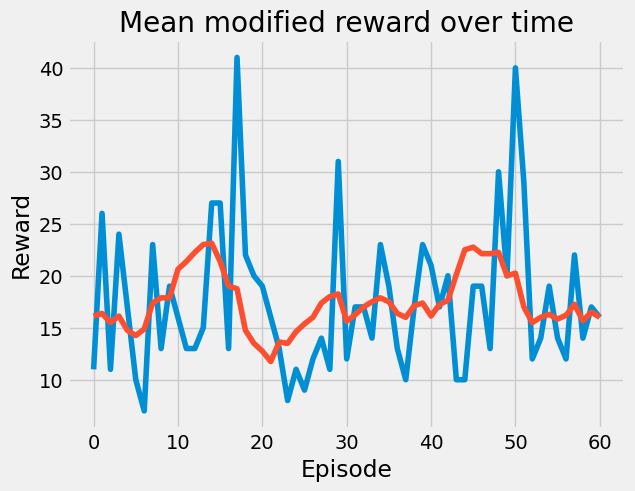

In [15]:
window_size = 8
mean_scores = [
    sum(scores[i : i + window_size]) / len(scores[i : i + window_size])
    for i in range(len(scores))
]
plt.style.use("fivethirtyeight")
plt.plot(scores)
plt.plot(mean_scores)
plt.title("Mean modified reward over time")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

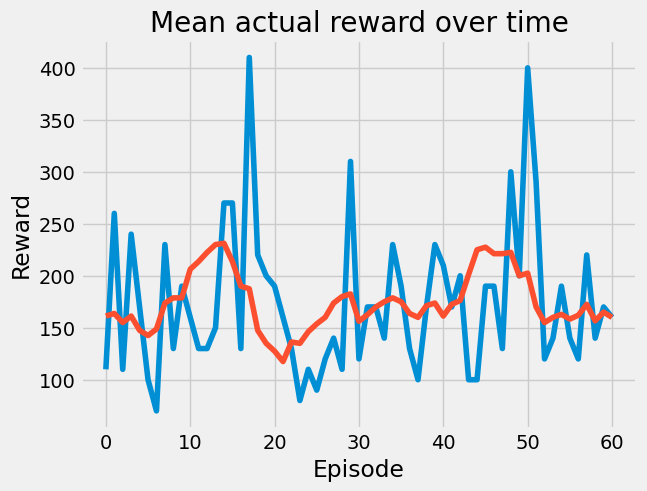

In [16]:
window_size = 8
mean_scores = [
    sum(actual_scores[i : i + window_size]) / len(actual_scores[i : i + window_size])
    for i in range(len(actual_scores))
]
plt.style.use("fivethirtyeight")
plt.plot(actual_scores)
plt.plot(mean_scores)
plt.title("Mean actual reward over time")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

In [17]:
# env = pacman_rl.make(config, pacman_rl.RenderMode.HUMAN)
steps = 0
state = env.reset()
prev_score = 0
score = 0
done = False

while not state.completed:
    env.render()
    filename = env.get_snapshot()
    img = Image.open(filename).convert("RGB")
    image_stack.step(preprocess(img))

    current_images = image_stack.item().detach().cpu().numpy()
    action = agent.get_testing_action(current_images)
    action = pacman_rl.MovementDirection(action)

    new_state = env.step(action)
    reward = (new_state.score - prev_score) / 10
    score += reward

    state = new_state
    prev_score = state.score
    steps += 1

print(round(score, 3))

52.0


In [18]:
env.close()

ffmpeg -y -framerate 24 -i recordings/tmp/%08d.png -c:v libx264 -pix_fmt yuv420p recordings/recording.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [19]:
# scores = []
# actual_scores = []

# for i in range(num_episodes):
#     steps = 0
#     state = env.reset()
#     prev_score = 0
#     score = 0
#     done = False

#     while not state.completed:
#         action = agent.get_training_action(encode_grid(state.grid))
#         action = pacman_rl.MovementDirection(action)

#         new_state = env.step(action)
#         reward = (new_state.score - prev_score) / 10

#         score += reward
#         agent.memory.store_transition(
#             encode_grid(state.grid), action, reward, encode_grid(new_state.grid), new_state.completed
#         )
#         agent.learn()
#         steps += 1

#         state = new_state
#         prev_score = state.score

#     if agent.epsilon <= agent.min_epsilon:
#         for _ in range(num_learning_steps):
#             agent.learn()

#     scores.append(score)
#     actual_scores.append(state.score)
#     print(f"Episode: {i}, Steps: {steps:3}, Score: {score:.3f}, Actual Score: {state.score}")

In [20]:
# agent.save_model()

In [23]:
# window_size = 8
# mean_scores = [
#     sum(scores[i : i + window_size]) / len(scores[i : i + window_size])
#     for i in range(len(scores))
# ]
# plt.style.use("fivethirtyeight")
# plt.plot(scores)
# plt.plot(mean_scores)
# plt.title("Mean reward over time")
# plt.xlabel("Episode")
# plt.ylabel("Reward")
# plt.show()

In [22]:
# window_size = 8
# mean_scores = [
#     sum(actual_scores[i : i + window_size]) / len(actual_scores[i : i + window_size])
#     for i in range(len(actual_scores))
# ]
# plt.style.use("fivethirtyeight")
# plt.plot(actual_scores)
# plt.plot(mean_scores)
# plt.title("Mean reward over time")
# plt.xlabel("Episode")
# plt.ylabel("Reward")
# plt.show()

In [21]:
# env = pacman_rl.make(config, pacman_rl.RenderMode.HUMAN)
# steps = 0
# state = env.reset()
# prev_score = 0
# score = 0
# done = False

# while not state.completed:
#     action = agent.get_training_action(encode_grid(state.grid))
#     action = pacman_rl.MovementDirection(action)

#     new_state = env.step(action)
#     reward = (new_state.score - prev_score - 1.5) / 10
#     score += reward

#     IPython.display.clear_output(wait=True)
#     env.render()
#     time.sleep(0.1)

#     state = new_state
#     prev_score = state.score
#     steps += 1

# env.close()
# print(round(score, 3))